<a href="https://colab.research.google.com/github/Aseesah-W/deeplearning_final/blob/main/Deep_Learning_Based_Nail_Health_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ===========================
# 1. Install & Import Packages
# ===========================
!pip install torch torchvision torchaudio matplotlib seaborn scikit-learn
!pip install kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import os

import kagglehub

path = kagglehub.dataset_download("nikhilgurav21/nail-disease-detection-dataset")

print("📁 Dataset downloaded to:", path)

import os

for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

# ===========================
# 2. Config
# ===========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 6  # healthy + 5 diseases
IMAGE_SIZE = 224

#DATASET_PATH = "/kaggle/input/nail-disease-detection-dataset/data"  # update path in Colab
DATASET_PATH = os.path.join(path, "data")

100%|██████████| 63.8M/63.8M [00:00<00:00, 223MB/s]


Extracting files...
📁 Dataset downloaded to: /root/.cache/kagglehub/datasets/nikhilgurav21/nail-disease-detection-dataset/versions/1
1/
  data/
    train/
      Acral_Lentiginous_Melanoma/
        Screen-Shot-2021-11-20-at-8-29-41-PM_png.rf.e102e85876de2207df7b2093e9c83244.jpg
        Screen-Shot-2021-11-19-at-2-17-25-AM_png.rf.8fe28dc2f1a4f9d7627e249727186336.jpg
        Screen-Shot-2021-11-19-at-1-43-09-AM_png.rf.a130fb33907253a35d87b378b9a74f1b.jpg
        Screen-Shot-2021-11-20-at-8-35-31-PM_png.rf.6a3312d0b79ec6c6b8895845550980a0.jpg
        Screen-Shot-2021-11-19-at-1-38-40-AM_png.rf.1ac3e3db64655a0b6cc6cefb4d9ebd62.jpg
        Screen-Shot-2021-11-20-at-7-55-58-PM_png.rf.30cc430c4c521b78a21dc7c239145452.jpg
        Screen-Shot-2021-11-19-at-2-28-45-AM_png.rf.760843e269844644d897f22ae095643e.jpg
        Screen-Shot-2021-11-19-at-12-38-04-AM_png.rf.402c111a83e6e7b2028e813289c9bbd2.jpg
        Screen-Shot-2021-11-20-at-8-08-29-PM_png.rf.47d0d70270f490279530e8866203d037.jpg
        9

In [3]:
# ===========================
# 3. Data Augmentation & Loader
# ===========================
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "validation"), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']


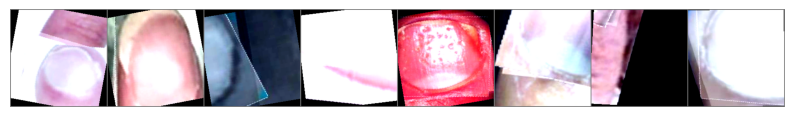

clubbing        clubbing        clubbing        clubbing        pitting         blue_finger     blue_finger     clubbing       


In [4]:
#Visualize Sample Images
import torchvision.utils as vutils

def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(vutils.make_grid(images[:8]))
print(' '.join(f'{class_names[labels[j]]:15s}' for j in range(8)))


In [5]:
# ===========================
# 4. Spatial Attention Block
# ===========================
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)


In [6]:
# ===========================
# 5. ResNet18 + Attention Model
# ===========================
class ResNet18WithAttention(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # Remove avgpool & fc
        self.attn = SpatialAttention()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        attn_map = self.attn(x)
        x = x * attn_map
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ResNet18WithAttention().to(DEVICE)
print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]

ResNet18WithAttention(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [7]:
# ===========================
# 6. Loss & Optimizer
# ===========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Epoch [1/10] Train Loss: 0.9951, Train Acc: 62.45% Val Loss: 0.3632, Val Acc: 87.91%
Epoch [2/10] Train Loss: 0.6242, Train Acc: 77.03% Val Loss: 0.2816, Val Acc: 87.91%


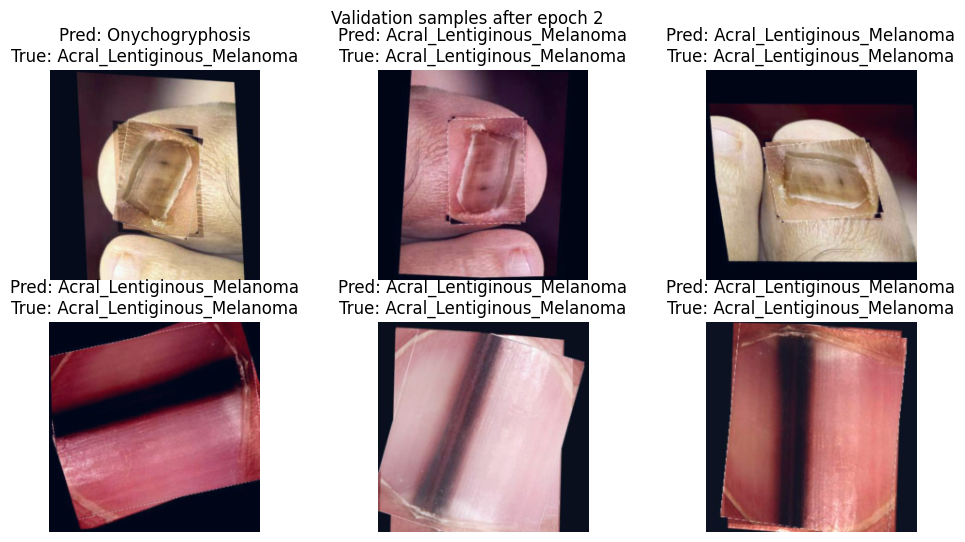

Epoch [3/10] Train Loss: 0.5220, Train Acc: 80.80% Val Loss: 0.2957, Val Acc: 90.11%
Epoch [4/10] Train Loss: 0.5048, Train Acc: 82.21% Val Loss: 0.2729, Val Acc: 92.31%


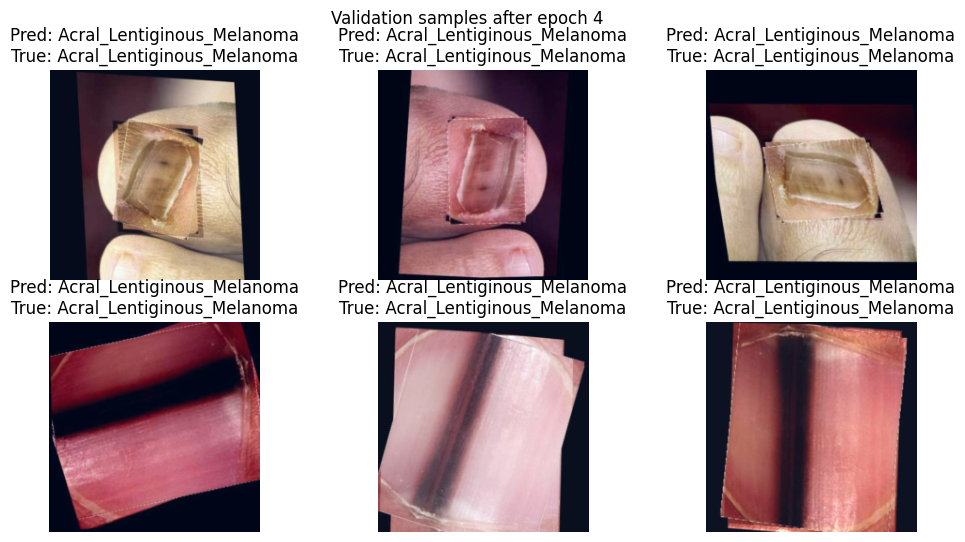

Epoch [5/10] Train Loss: 0.4578, Train Acc: 83.39% Val Loss: 0.1491, Val Acc: 95.60%
Epoch [6/10] Train Loss: 0.3984, Train Acc: 85.63% Val Loss: 0.2788, Val Acc: 85.71%


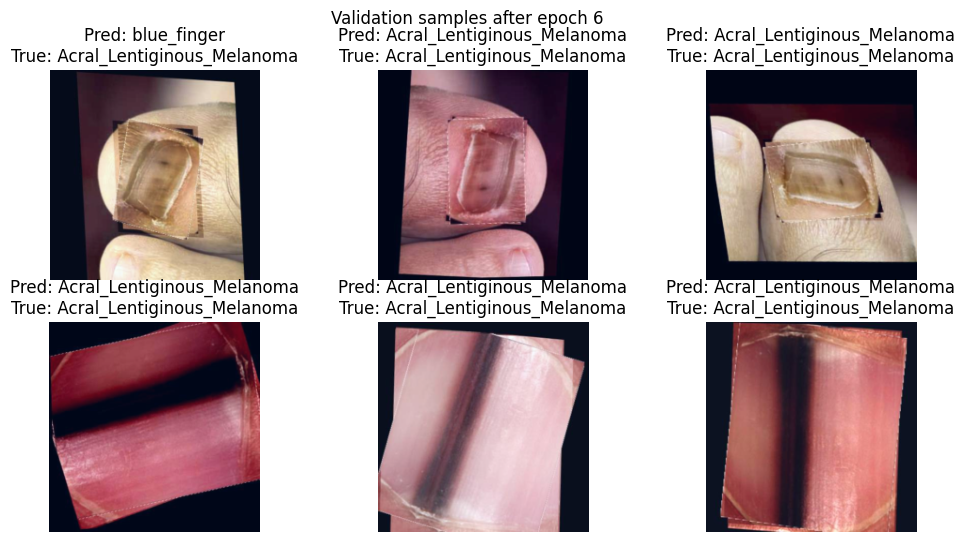

Epoch [7/10] Train Loss: 0.3735, Train Acc: 86.40% Val Loss: 0.3460, Val Acc: 85.71%
Epoch [8/10] Train Loss: 0.3787, Train Acc: 86.08% Val Loss: 0.2438, Val Acc: 90.11%


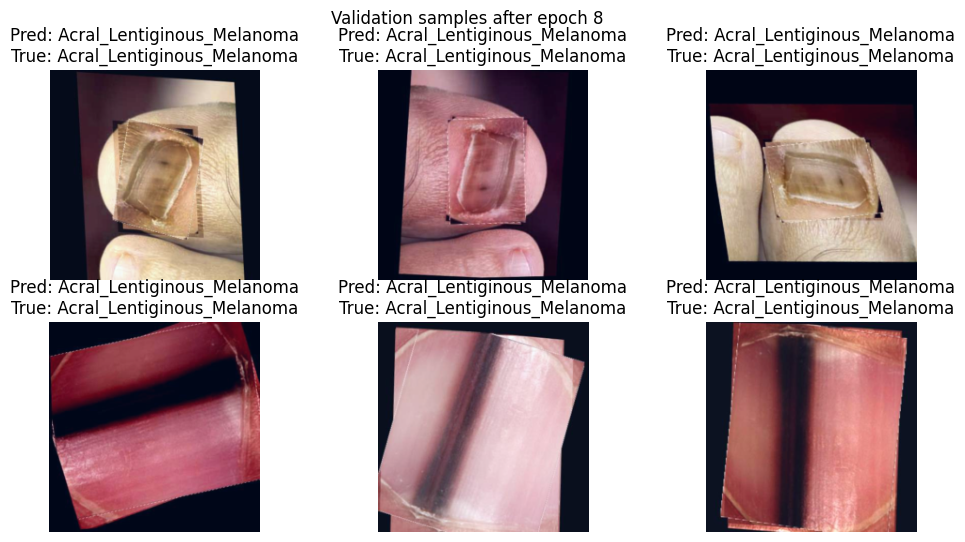

Epoch [9/10] Train Loss: 0.3232, Train Acc: 88.33% Val Loss: 0.3461, Val Acc: 89.01%
Epoch [10/10] Train Loss: 0.3592, Train Acc: 86.99% Val Loss: 0.3157, Val Acc: 86.81%


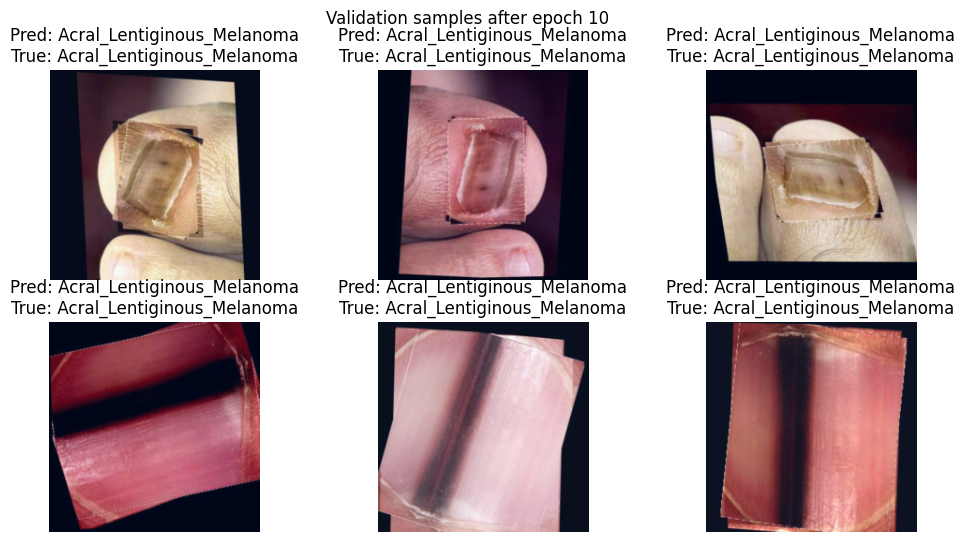

In [8]:
# ===========================
# 7. Training Loop
# ===========================
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss/total)
    train_acc.append(correct/total)

    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0,0,0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_losses.append(val_loss/total_val)
    val_acc.append(correct_val/total_val)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]*100:.2f}% "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]*100:.2f}%")

        # 🔹 Show predictions every 2 epochs
    if (epoch+1) % 2 == 0:
        images, labels = next(iter(val_loader))
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        plt.figure(figsize=(12, 6))
        for i in range(6):
            plt.subplot(2, 3, i+1)
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            plt.imshow(img)
            plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
            plt.axis('off')
        plt.suptitle(f"Validation samples after epoch {epoch+1}")
        plt.show()

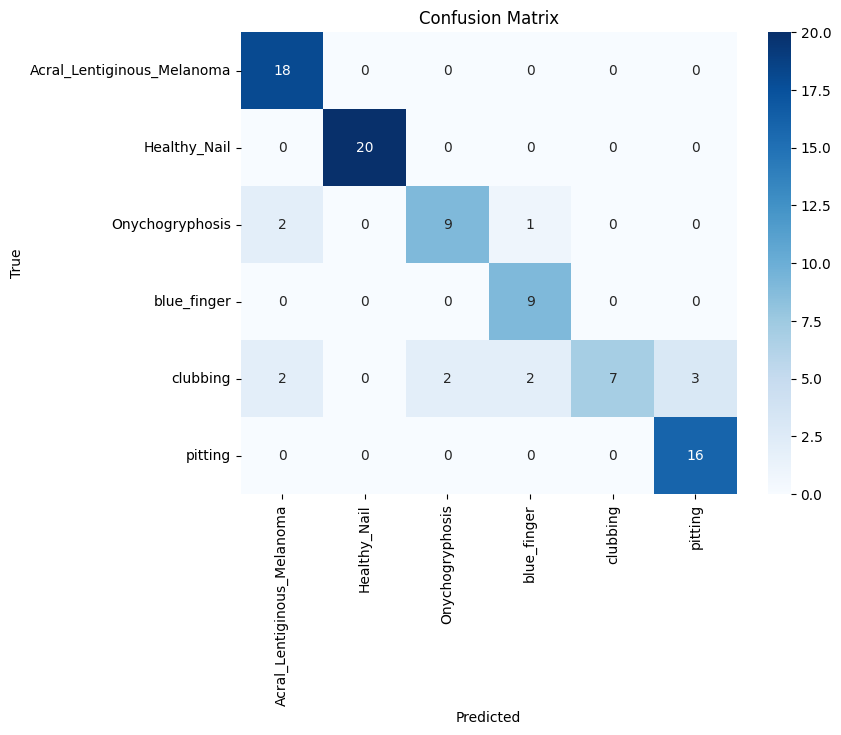

In [9]:
# ===========================
# 9. Confusion Matrix
# ===========================
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


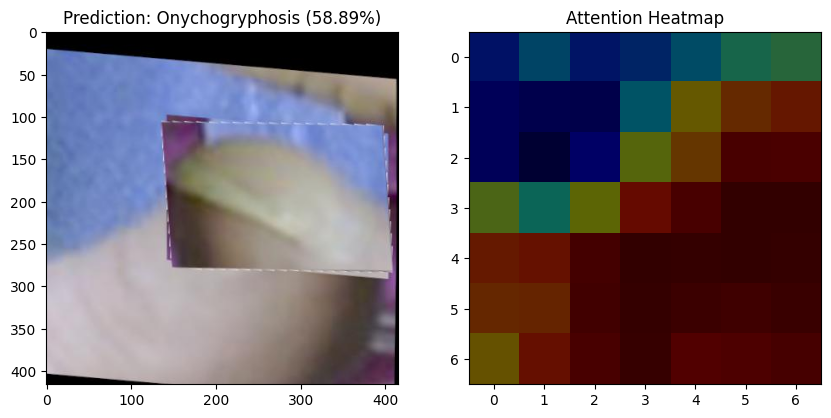

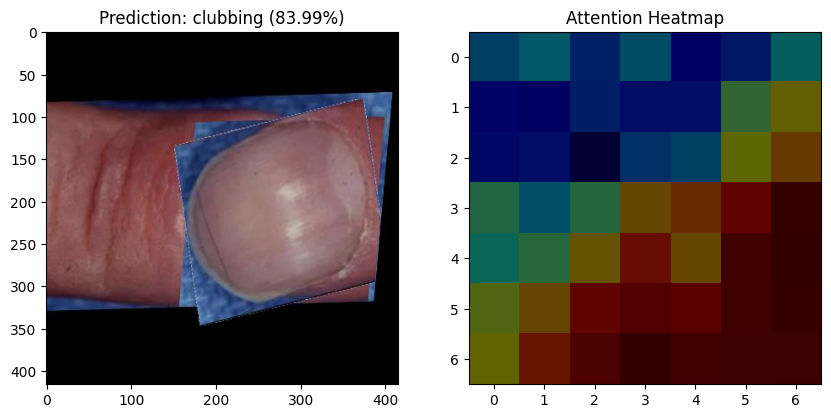

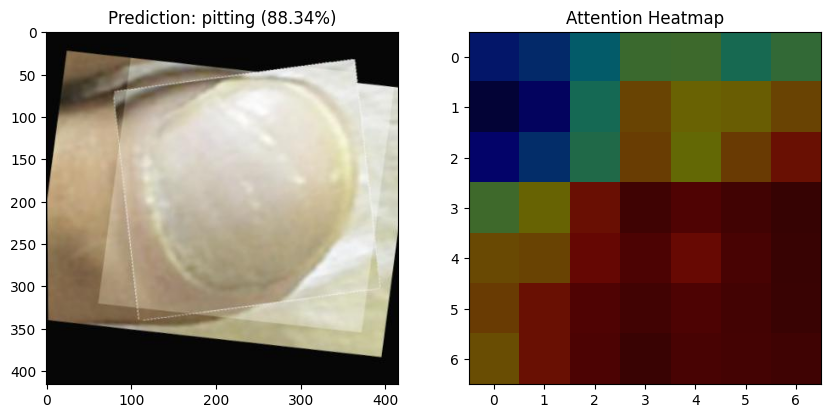

In [18]:
from PIL import Image
def visualize_attention(model, image_path, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = val_transforms
    img_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, dim=1)

        # attention visualization (ตัวอย่าง)
        features = model.features(img_tensor)
        attn_map = model.attn(features)
        attn_map = attn_map.squeeze().cpu().numpy()
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Prediction: {class_names[pred.item()]} ({conf.item()*100:.2f}%)")

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(attn_map, cmap='jet', alpha=0.4)
    plt.title("Attention Heatmap")
    plt.show()

visualize_attention(model, f"{DATASET_PATH}/validation/clubbing/Screen-Shot-2021-10-26-at-12-10-57-PM_png.rf.13d80dc781bd7e9b4d1c2c67ecbacb55.jpg",class_names)
visualize_attention(model, f"{DATASET_PATH}/validation/clubbing/Screen-Shot-2021-10-26-at-12-11-28-PM_png.rf.4f993b88f526fd3ce51dc24eeae5b4d2.jpg",class_names)
visualize_attention(model, f"{DATASET_PATH}/validation/clubbing/Screen-Shot-2021-10-26-at-12-07-03-PM_png.rf.3514795dcb0a1e7bbbd78fd0acc2ac7b.jpg",class_names)


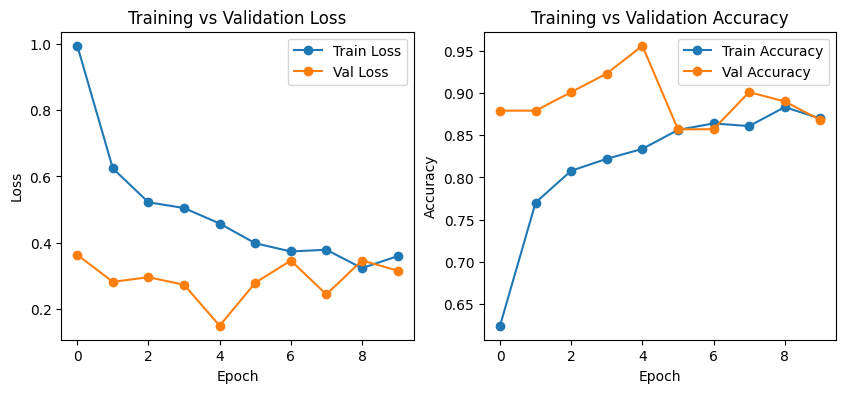

In [27]:
# ===========================
# 8. Plot Loss & Accuracy
# ===========================
plt.figure(figsize=(10,4))

# --- กราฟ Loss ---
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- กราฟ Accuracy ---
plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
